In [1]:
import sionna as sn
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

2023-06-08 09:20:43.713549: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-08 09:20:43.715028: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 09:20:43.747597: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 09:20:43.747906: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 09:20:44.339811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
BATCH_SIZE = 10
NUM_BITS_PER_SYMBOL = 4
snrs = np.linspace(-5,10, 16);
CODERATE = 0.5
NUM_CODED_BITS = 1000
NUM_INFO_BITS = int(NUM_CODED_BITS * CODERATE)

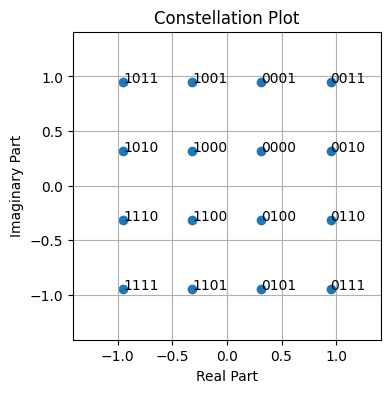

In [3]:
constellation = sn.mapping.Constellation('qam', NUM_BITS_PER_SYMBOL)
constellation.show(figsize=(4,4));

In [4]:
binary_source = sn.utils.BinarySource()

mapper = sn.mapping.Mapper(constellation=constellation)
demapper = sn.mapping.Demapper('app', constellation=constellation)

ldpc_encoder = sn.fec.ldpc.LDPC5GEncoder(NUM_INFO_BITS, NUM_CODED_BITS)
ldpc_decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=ldpc_encoder, hard_out=True)

awgn = sn.channel.AWGN()

In [7]:
bits = binary_source([BATCH_SIZE, NUM_INFO_BITS])
coded_bits = ldpc_encoder(bits)
symbols_with_coding = mapper(coded_bits)
symbols_no_coding = mapper(bits)

bers_with_coding = []
bers_no_coding = []

for SNR in snrs:
  no_with_coding = sn.utils.ebnodb2no(
    coderate=CODERATE,
    ebno_db=SNR,
    num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
  )
  no_no_coding = sn.utils.ebnodb2no(
    coderate=1,
    ebno_db=SNR,
    num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
  )

  received_symbols_with_coding = awgn([symbols_with_coding, no_with_coding])
  received_symbols_no_coding = awgn([symbols_no_coding, no_no_coding])

  llr_with_coding = demapper([received_symbols_with_coding, no_with_coding])
  llr_no_coding = demapper([received_symbols_no_coding, no_no_coding])

  bits_hat_with_coding = ldpc_decoder(llr_with_coding)
  bits_hat_no_coding = np.array(llr_no_coding>0, dtype='uint8')

  ber_with_coding = sn.utils.compute_ber(bits, bits_hat_with_coding)
  ber_no_coding = sn.utils.compute_ber(bits, bits_hat_no_coding)

  bers_with_coding.append(ber_with_coding)
  bers_no_coding.append(ber_no_coding)

  print(f'SNR = {SNR} | WITH CODING BER = {ber_with_coding} | NO CODING BER = {ber_no_coding}')

SNR = -5.0 | WITH CODING BER = 0.3658 | NO CODING BER = 0.2636
SNR = -4.0 | WITH CODING BER = 0.3556 | NO CODING BER = 0.2218
SNR = -3.0 | WITH CODING BER = 0.3162 | NO CODING BER = 0.2108
SNR = -2.0 | WITH CODING BER = 0.3128 | NO CODING BER = 0.1838
SNR = -1.0 | WITH CODING BER = 0.2776 | NO CODING BER = 0.1598
SNR = 0.0 | WITH CODING BER = 0.2624 | NO CODING BER = 0.1516
SNR = 1.0 | WITH CODING BER = 0.224 | NO CODING BER = 0.122
SNR = 2.0 | WITH CODING BER = 0.1688 | NO CODING BER = 0.096
SNR = 3.0 | WITH CODING BER = 0.062 | NO CODING BER = 0.0782
SNR = 4.0 | WITH CODING BER = 0.008 | NO CODING BER = 0.0522
SNR = 5.0 | WITH CODING BER = 0.0 | NO CODING BER = 0.0396
SNR = 6.0 | WITH CODING BER = 0.0 | NO CODING BER = 0.0254
SNR = 7.0 | WITH CODING BER = 0.0 | NO CODING BER = 0.0156
SNR = 8.0 | WITH CODING BER = 0.0 | NO CODING BER = 0.0108
SNR = 9.0 | WITH CODING BER = 0.0 | NO CODING BER = 0.006
SNR = 10.0 | WITH CODING BER = 0.0 | NO CODING BER = 0.0024


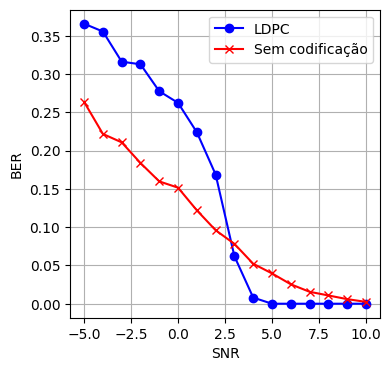

In [8]:
plt.figure(figsize=(4,4))
plt.plot(snrs, bers_with_coding, color='b', marker='o')
plt.plot(snrs, bers_no_coding, color='r', marker='x')
plt.xlabel('SNR')
plt.ylabel('BER')
plt.grid()
plt.legend(['LDPC', 'Sem codificação'])